# Load data

<https://www.kaggle.com/c/bike-sharing-demand>

In [1]:
import sage
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Load data
df = sage.datasets.bike()
feature_names = df.columns.tolist()[:-3]

In [3]:
# Split data, with total count serving as regression target
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=123)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=123)
Y_train = train[:, -1].copy()
Y_val = val[:, -1].copy()
Y_test = test[:, -1].copy()
train = train[:, :-3].copy()
val = val[:, :-3].copy()
test = test[:, :-3].copy()

# Train model

In [4]:
import xgboost as xgb

In [5]:
# Set up data
dtrain = xgb.DMatrix(train, label=Y_train)
dval = xgb.DMatrix(val, label=Y_val)

# Parameters
param = {
    'max_depth' : 10,
    'objective': 'reg:squarederror',
    'nthread': 4
}
evallist = [(dtrain, 'train'), (dval, 'val')]
num_round = 50

# Train
model = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)

In [6]:
# Calculate performance
mean = np.mean(Y_train)
base_mse = np.mean((mean - Y_test) ** 2)
mse = np.mean((model.predict(xgb.DMatrix(test)) - Y_test) ** 2)

print('Base rate MSE = {:.2f}'.format(base_mse))
print('Model MSE = {:.2f}'.format(mse))

Base rate MSE = 31591.23
Model MSE = 1920.86


# Check SAGE calibration

In [7]:
# Setup and calculate
imputer = sage.MarginalImputer(model, test[:512])
estimator = sage.PermutationEstimator(imputer, 'mse')

# Run explainer multiple times
sage_list = []
for i in range(20):
    sage_list.append(estimator(test, Y_test, n_permutations=512*5, bar=False, detect_convergence=False))
    print('Done with run {}'.format(i))

Done with run 0
Done with run 1
Done with run 2
Done with run 3
Done with run 4
Done with run 5
Done with run 6
Done with run 7
Done with run 8
Done with run 9
Done with run 10
Done with run 11
Done with run 12
Done with run 13
Done with run 14
Done with run 15
Done with run 16
Done with run 17
Done with run 18
Done with run 19


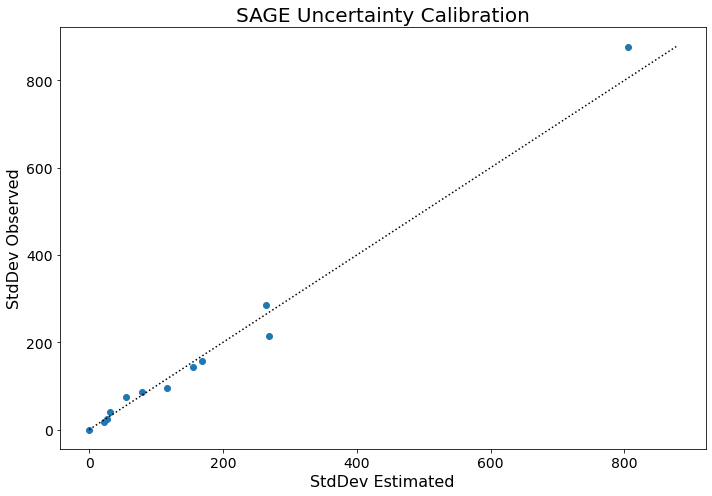

In [8]:
plt.figure(figsize=(10, 7))

# Scatter plot
std_est = sage_list[0].std
std_real = np.std(np.array([sage_values.values for sage_values in sage_list]), axis=0)
plt.scatter(std_est, std_real)

# Y = X line
m = max(std_est.max(), std_real.max())
plt.plot([0, m,], [0, m], color='black', linestyle=':')

plt.xlabel('StdDev Estimated', fontsize=16)
plt.ylabel('StdDev Observed', fontsize=16)
plt.title('SAGE Uncertainty Calibration', fontsize=20)
plt.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

# Check Relaxed SAGE calibration

In [9]:
# Setup and calculate
imputer = sage.MarginalImputer(model, test[:512])
estimator = sage.PermutationEstimator(imputer, 'mse')

# Run explainer multiple times
sage_list = []
for i in range(20):
    sage_list.append(estimator(test, Y_test, n_permutations=512*5, bar=False, detect_convergence=False, min_coalition=6))
    print('Done with run {}'.format(i))

Done with run 0
Done with run 1
Done with run 2
Done with run 3
Done with run 4
Done with run 5
Done with run 6
Done with run 7
Done with run 8
Done with run 9
Done with run 10
Done with run 11
Done with run 12
Done with run 13
Done with run 14
Done with run 15
Done with run 16
Done with run 17
Done with run 18
Done with run 19


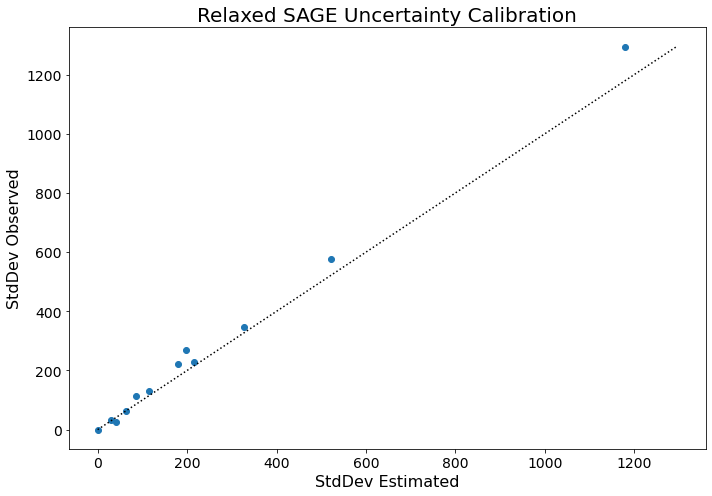

In [10]:
plt.figure(figsize=(10, 7))

# Scatter plot
std_est = sage_list[0].std
std_real = np.std(np.array([sage_values.values for sage_values in sage_list]), axis=0)
plt.scatter(std_est, std_real)

# Y = X line
m = max(std_est.max(), std_real.max())
plt.plot([0, m,], [0, m], color='black', linestyle=':')

plt.xlabel('StdDev Estimated', fontsize=16)
plt.ylabel('StdDev Observed', fontsize=16)
plt.title('Relaxed SAGE Uncertainty Calibration', fontsize=20)
plt.tick_params(labelsize=14)

plt.tight_layout()
plt.show()